### 依赖安装 shell 脚本 repes_install.sh
```bash
# 内容
pip install nibabel
pip install albumentations
mkdir logs model
```

In [24]:
!bash repes_install.sh

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple


### 数据载入与增强

+ 数据增强手段使用了 中心随机裁剪、水平翻转和旋转等。
+ 训练集、验证集和测试集的 batch size 均设置为 2

In [59]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import nibabel as nib
from nibabel.viewers import OrthoSlicer3D

train_path = glob.glob('./pet_brain/Train/*/*')
test_path = glob.glob('./pet_brain/Test/*')

np.random.shuffle(train_path)
np.random.shuffle(test_path)

DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        if self.img_path[index] in DATA_CACHE:
            img = DATA_CACHE[self.img_path[index]]
        else:
            img = nib.load(self.img_path[index]) 
            img = img.dataobj[:,:,:, 0]
            DATA_CACHE[self.img_path[index]] = img
        
        # 随机选择一些通道            
        idx = np.random.choice(range(img.shape[-1]), 50)
        img = img[:, :, idx]
        img = img.astype(np.float32)

        if self.transform is not None:
            img = self.transform(image = img)['image']
        
        img = img.transpose([2,0,1])
        return img,torch.from_numpy(np.array(int('NC' in self.img_path[index])))
    
    def __len__(self):
        return len(self.img_path)
        
import albumentations as A
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-10],
            A.Compose([
            A.RandomRotate90(),
            A.RandomCrop(120, 120),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-10:],
            A.Compose([
            A.RandomCrop(120, 120),
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
            A.Compose([
            A.RandomCrop(128, 128),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)


### 训练与验证

In [16]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        output = model(input)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()
            output = model(input)
            loss = criterion(output, target)
            val_acc += (output.argmax(1) == target).sum().item()
            
    return val_acc / len(val_loader.dataset)

### 定义模型

In [49]:
pretrain_models = {
    'resnet18': models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
    'resnet34': models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1),
    'resnet50': models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
}

class XunFeiNet(nn.Module):
    def __init__(self,pretrain='resnet18'):
        super(XunFeiNet, self).__init__()
                
        model = pretrain_models[pretrain]
        model.conv1 = torch.nn.Conv2d(50, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        if pretrain != 'resnet50':
            model.fc = nn.Linear(512, 2)
        else:
            model.fc = nn.Linear(2048, 2)
        self.net = model
        
    def forward(self, img):        
        out = self.net(img)
        return out

### 进行训练并记录
分别使用 resnet18，resnet34，resnet50 的预训练模型进行训练和识别任务。

+ 训练结果

|模型|学习率|best val accuracy(%)|
|-|-|-|
|resnet18|0.0001|100.0%|
|resnet34|0.0001|90.0%|
||0.0005|70.0%|
|resnet50|0.0001|90.0%|
||0.0005|90.0%|
||0.001|80.0%|

In [39]:
from datetime import datetime
class HisRecorder:
    def __init__(self,log_name='test'):
        self.name = log_name
        self.history = {}
    def record_info(self,epoch,train_loss,train_acc,val_acc):
        self.history[epoch] = (train_loss,train_acc,val_acc)
    def save_hist(self):
        t = datetime.now().strftime('%Y-%m-%d-%H-%M')
        fname = self.name + '_' + t
        f = open('./logs/'+fname,'w',encoding='utf-8')
        f.write(str(self.history))
        f.close()
    def clean_hist(self):
        self.history = {}

def save_check(model,optim,sche,best_acc,epoch,name='test'):
    stat = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
            'optimizer' : optim.state_dict(),
            'scheduler' : sche.state_dict()
        }
    torch.save(stat,f'./model/{name}_best.pth.tar')

#### 训练设置
一共迭代训练 100 次。起始学习率 设置为 0.0001，之后在训练中使用 CosineAnnealingLR 对学习率进行调整。优化器 使用 AdamW。


In [60]:
pretrain = 'resnet18'
epochs = 100
model = XunFeiNet(pretrain)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), 0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,epochs+10)
recorder = HisRecorder(pretrain)

In [ ]:
best_acc = 0.
for epoch  in range(1,epochs+1):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc  = validate(val_loader, model, criterion)
    train_acc = validate(train_loader, model, criterion)
    if best_acc <= val_acc:
        best_acc = val_acc
        save_check(model,optimizer,scheduler,best_acc,epoch,pretrain)
    scheduler.step()
    recorder.record_info(epoch,train_loss,train_acc,val_acc)
    print(f'Epoch: {epoch:03}  Train Loss: {train_loss:.8f}  Train Acc: {train_acc:.6f}  Val Acc: {val_acc:.6f}')
print(f'Best acc: {best_acc}')

In [45]:
recorder.save_hist() # 训练日志

### 训练曲线可视化

In [62]:
import matplotlib.pyplot as plt

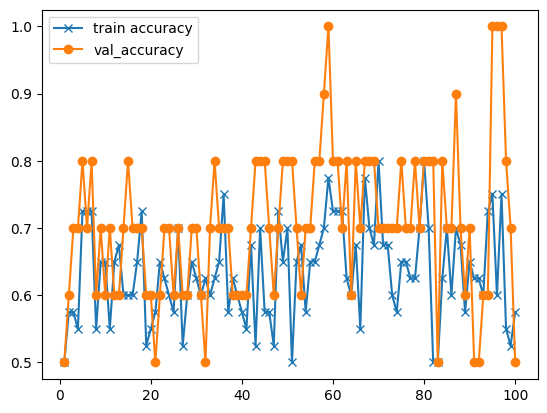

In [81]:
f = open('./logs/resnet18_2023-08-16-14-57','r',encoding='utf-8')
hist = eval(f.read())

ep_arr = []
train_acc = []
val_acc = []

for ep,info in hist.items():
    ep_arr.append(ep)
    train_acc.append(info[1])
    val_acc.append(info[2])

plt.plot(ep_arr,train_acc,marker='x',label='train accuracy')
plt.plot(ep_arr,val_acc,marker='o',label='val_accuracy')
plt.legend()

### 模型测试与提交

In [82]:
def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    test_pred = []
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()
            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)

In [93]:
# 加载训练好的模型
model = model = XunFeiNet('resnet18')
chep = torch.load('./model/resnet18_best.pth.tar')
model.load_state_dict(chep['state_dict'])
model.cuda()
# 进行测试、转化结果并将其存到csv文件中
pred = None
for _ in range(10):
    if pred is None:
        pred = predict(test_loader, model, criterion)
    else:
        pred += predict(test_loader, model, criterion)
        
submit = pd.DataFrame(
    {
        'uuid': [int(x.split('/')[-1][:-4]) for x in test_path],
        'label': pred.argmax(1)
})
submit['label'] = submit['label'].map({1:'NC', 0: 'MCI'})
submit = submit.sort_values(by='uuid')
submit.to_csv('submit2.csv', index=None)